# Importing from modules

In [14]:
# imports
import pickle
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import StratifiedKFold, train_test_split
import lime
import lime.lime_tabular
import shap
from sklearn.inspection import permutation_importance
from typing import Tuple, Union, Optional, Callable
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
from importlib import reload
import constants
import data_utils
import models
import training_and_selection
import plot_accuracies

In [18]:
reload(constants)
reload(models)
from constants import (
    SEED,
    NUM_SPLITS,
    INITIAL_CUTOFF,
    TOP,
    TARGET,
    MODEL_ACCURACIES_PATH,
    FILTERED_MODEL_ACCURACIES_PATH,
    TIME_LIMIT,
    TIME_LIMIT_CROSS_VALIDATION,
    RASHOMON_SETS_PATH,
    INITIAL_ACCURACIES_PATH
)
from models import MODELS, HYPERPARAMETERS

In [16]:
reload(data_utils)
from data_utils import get_dataset

X, y = get_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=(SEED+1))
BASELINE = np.sum(y == 1) / np.sum(y == 0)

/home/krzaq/xai/XAI-team-project/data_utils.py:20: DtypeWarning: Columns (4,11,12,16,17,18,19,20,40,41,42,43,44,45,52,53,54,55,56,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,108,110) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv("SpeedDating.csv", index_col=0)


In [19]:
reload(constants)
reload(training_and_selection)
from training_and_selection import get_rashomon_sets

rashomon_sets_params = get_rashomon_sets(
    models=MODELS,
    hyperparameters=HYPERPARAMETERS,
    X=X,
    y=y,
    initial_cutoff=0.15,
    top=0.04,
    initial_time_limit=50,
    cross_validation_time_limit=60,
    initial_path='results/initial_grid_search.csv',
    cross_validation_path='results/cross_validation_results.csv',
)
pickle.dump(rashomon_sets_params, open(RASHOMON_SETS_PATH, 'wb'))

SVMClassifier 320
TabRClassifier 293
XGBClassifier 288
SVMClassifier


0it [00:00, ?it/s]/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=30000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
720it [00:06, 108.45it/s]


TabRClassifier


288it [00:00, 639132.04it/s]


XGBClassifier


288it [00:01, 188.99it/s]
48it [00:00, 492241.06it/s]
43it [00:00, 452017.72it/s]
43it [00:00, 488767.13it/s]


In [5]:
rashomon_sets_params = pickle.load(open('rashomon_sets_params.pickle', 'rb'))

In [ ]:
rashomon_sets = {}
rashomon_sets_acc_lower_bounds = {}
accuracies = {}
for model_class in MODELS:
    rashomon_sets[model_class.__name__] = []
    accuracies[model_class.__name__] = []
    for kwargs in rashomon_sets_params[model_class.__name__]:
        if model_class.__name__ == 'SVMClassifier':
            model = model_class(probability=True, **kwargs)
        else:
            model = model_class(**kwargs)
        model.fit(X_train, y_train)
        acc = np.mean(model.predict(X_test) == np.array(y_test))
        accuracies[model_class.__name__].append(acc)
        rashomon_sets[model_class.__name__].append(model)
    rashomon_sets_acc_lower_bounds[model_class.__name__] = min(accuracies[model_class.__name__])

# XAI things

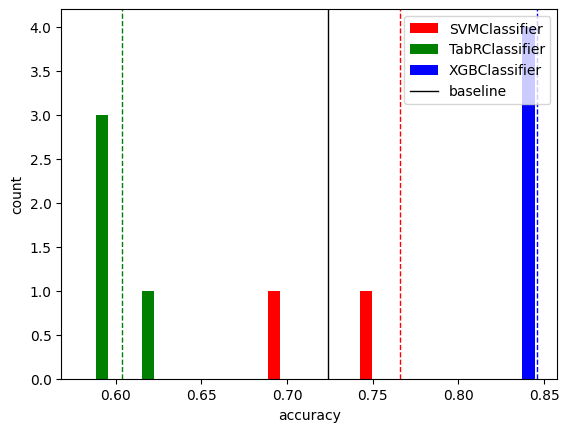

In [32]:
accuracies = pickle.load(open(INITIAL_ACCURACIES_PATH, 'rb'))

reload(plot_accuracies)
from plot_accuracies import plot_accuracies_

plot_accuracies_(accuracies, BASELINE)

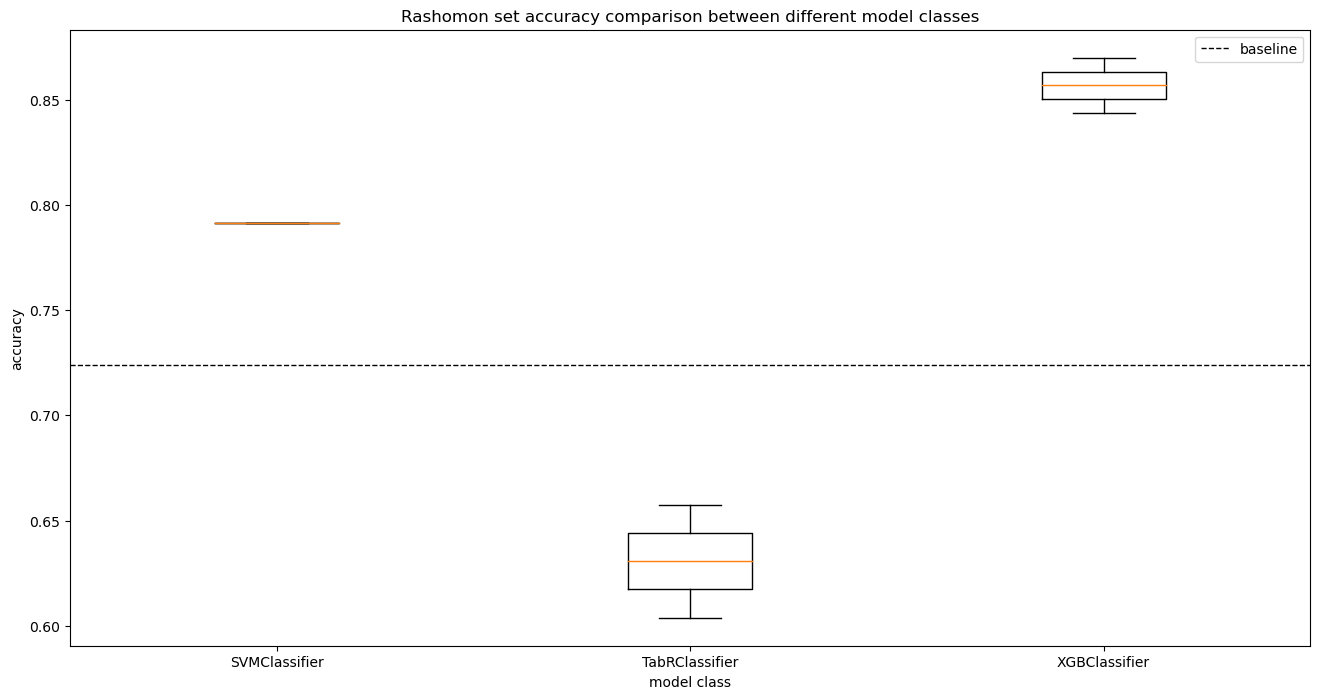

In [8]:
# Compare accuracies for different Rashomon sets
plt.figure(figsize=(16, 8))
plt.title("Rashomon set accuracy comparison between different model classes")
plt.axhline(BASELINE, color='black', linestyle='--', linewidth=1, label='baseline')
plt.xlabel('model class')
plt.ylabel('accuracy')
plt.boxplot([accuracies[model_class.__name__] for model_class in MODELS])
plt.xticks(np.arange(1, 1+len(MODELS)), [model_class.__name__ for model_class in MODELS])
plt.legend()

In [9]:
INDICES = [42, 123, 314]
RANDOM_SAMPLES = [X_test.iloc[i, :] for i in INDICES]

In [ ]:
# Permutation feature importance

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model_class in MODELS:
        for model in rashomon_sets[model_class.__name__]:
            importances = permutation_importance(model, X_test, y_test,
                           n_repeats=1,
                           random_state=SEED,
                            scoring="accuracy")
            importances = pd.Series(importances['importances'][:, 0], index=list(X.columns))
            fig, ax = plt.subplots()
            importances.plot.bar(ax=ax)
            ax.set_title("Permutation feature importances")
            ax.set_ylabel("importance")
            fig.tight_layout()

In [11]:
for model_class in MODELS:
    print(len(rashomon_sets[model_class.__name__]))

1
2
2


In [ ]:
# LIME
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    categorical_features = [0, 3, 4, -1]
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(X.to_numpy(), categorical_features=categorical_features, feature_names=list(X.columns), class_names=['negative', 'positive'])
    for model_class in MODELS:
        for model in rashomon_sets[model_class.__name__]:
            explaination = lime_explainer.explain_instance(X_test.iloc[SEED, :], model.predict_proba, num_features=5)
            fig = explaination.as_pyplot_figure()
            plt.plot()


In [13]:
# Shap
i = 0
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model_class in MODELS:
        for model in rashomon_sets[model_class.__name__]:
            i += 1
            if i <= 4:
                continue
            # if hasattr(model, "feature_names_in_"):
            # model.fit(X_train.values, y_train.values)
            print(type(X_train.iloc[:100, :]))
            shap_explainer = shap.KernelExplainer(model.predict, X_train.iloc[:100, :].to_numpy(), feature_names=list(X.columns))
            explaination = shap_explainer(X_test.iloc[[SEED], :])
            shap_values = explaination.values
            shap.plots.beeswarm(explaination)
            plt.plot()


<class 'pandas.core.frame.DataFrame'>


AttributeError: can't set attribute

In [ ]:
reload(training_and_selection)
torch.cuda.empty_cache()
from xgboost import XGBClassifier
from models import SVMClassifier, TabRClassifier
from training_and_selection import train_test_models


XGBCLASSIFIER_HYPERPARAMETERS = {
    'n_estimators': [100, 200, 400, 600],
    "max_depth": [6, 8, 10, 12],
    "min_child_weight": [1, 4],
    "eta": [0.1, 0.3, 0.6],
    "subsample": [0.5, 0.8, 1],
    # "lambda": [0, 0.2, 1, 5, 12, 25],
    # "alpha": [0, 0.2, 1, 5, 12, 25],
}

SVMCLASSIFIER_HYPERPARAMETERS = {
    "degree": [2, 3, 4, 5, 8, 10],
    "kernel": ['poly', 'rbf', 'sigmoid'],
    'C': [0.1, 0.25, 0.5, 1, 2, 4, 8, 16],
    'gamma': ['auto', 0.2, 0.5, 1, 4],
    'max_iter': [30000],
}

TABRCLASSIFIER_HYPERPARAMETERS = {
    'activation': ['SiLU', 'GELU', 'Sigmoid', 'ReLU'],
    'd_main': [128, 256],
    'd_multiplier': [1.5, 2, 4, 6],
    'dropout0': [0, 0.1, 0.25],
    'dropout1': ['dropout0'],
    'context_size': [16, 32, 64],
    'encoder_n_blocks': [2],
    'predictor_n_blocks': [2],
    'seed': [69],
    'max_epochs': [2]
}


MODELS = [TabRClassifier, SVMClassifier, XGBClassifier, ]
HYPERPARAMETERS = {
    XGBClassifier.__name__ : XGBCLASSIFIER_HYPERPARAMETERS,
    SVMClassifier.__name__ : SVMCLASSIFIER_HYPERPARAMETERS,
    TabRClassifier.__name__ : TABRCLASSIFIER_HYPERPARAMETERS
}

results = train_test_models(
    MODELS, 
    # {TabRClassifier.__name__ : TABRCLASSIFIER_HYPERPARAMETERS},
    HYPERPARAMETERS,
    X=X_train,
    y=y_train,
    path='tabr_tests.csv',
    limit=50,
)



TabRClassifier


0it [00:00, ?it/s]

/home/krzaq/xai/XAI-team-project/pytorch_tabr/base_model.py:162: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/home/krzaq/xai/XAI-team-project/pytorch_tabr/base_model.py:258: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


 epochs:   0%|          | 0/2 [00:00<?, ?it/s]

 batches:   0%|          | 0/271 [00:00<?, ?it/s]

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)
/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 8)
1it [00:15, 15.20s/it]

 epochs:   0%|          | 0/2 [00:00<?, ?it/s]

 batches:   0%|          | 0/271 [00:00<?, ?it/s]

Training stopped. Calling callbacks...


2it [00:27, 13.40s/it]

 epochs:   0%|          | 0/2 [00:00<?, ?it/s]

 batches:   0%|          | 0/271 [00:00<?, ?it/s]

In [7]:
import gc
gc.collect()

0